In [9]:
%load_ext autoreload

import numpy as np
import numpy.random as npr
import torch
import scipy as sp
from scipy import interpolate
from collections import defaultdict

import json
import pandas as pd
import os
from tqdm import tqdm
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.style.use('bmh')
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import dmc2gym

import pickle as pkl
import itertools
import operator
from collections import namedtuple
from glob import glob
import textwrap

import os
import yaml

import sys
# sys.path.append('../batch')
# %autoreload 2
# %aimport bcq

import omegaconf
from omegaconf import OmegaConf

%autoreload 2
from mve.analysis import plot_ac_exp, sweep_summary, plot_agg, plot_ablation

from IPython.display import display
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


best_eval_rew  \
                                                               mean   
env_name     agent.params.horizon env                                 
gym_ant      0                    poplin_ant             643.014032   
             3                    poplin_ant            4122.225089   
gym_cheetah  0                    poplin_cheetah        6438.790215   
             3                    poplin_cheetah        8432.874575   
gym_fswimmer 0                    poplin_swimmer         348.696376   
             3                    poplin_swimmer         349.320330   
gym_hopper   0                    poplin_hopper         2518.036729   
             3                    poplin_hopper         2025.479720   
gym_walker2d 0                    poplin_walker2d        -41.471134   
             3                    poplin_walker2d       1066.661732   
pets_cheetah 0                    poplin_pets_cheetah   2754.332943   
             3                    poplin_pets_cheetah   5542.182198   

                                                                    \
                                                               std   
env_name     agent.params.horizon env                                
gym_ant      0                    poplin_ant             26.879247   
             3                    poplin_ant            563.318607   
gym_cheetah  0                    poplin_cheetah       1479.891779   
             3                    poplin_cheetah       1129.152250   
gym_fswimmer 0                    poplin_swimmer          3.498413   
             3                    poplin_swimmer          5.811204   
gym_hopper   0                    poplin_hopper         967.286063   
             3                    poplin_hopper        1033.565303   
gym_walker2d 0                    poplin_walker2d       701.379557   
             3                    poplin_walker2d       703.921167   
pets_cheetah 0                    poplin_pets_cheetah   956.385867   
             3                    poplin_pets_cheetah   394.998303   

                                                      last_eval_rew  \
                                                               mean   
env_name     agent.params.horizon env                                 
gym_ant      0                    poplin_ant             589.030075   
             3                    poplin_ant            3987.429757   
gym_cheetah  0                    poplin_cheetah        6376.578884   
             3                    poplin_cheetah        8394.831405   
gym_fswimmer 0                    poplin_swimmer         348.696376   
             3                    poplin_swimmer         347.759071   
gym_hopper   0                    poplin_hopper         2290.016246   
             3                    poplin_hopper         1610.247287   
gym_walker2d 0                    poplin_walker2d       -185.847126   
             3                    poplin_walker2d        197.080729   
pets_cheetah 0                    poplin_pets_cheetah   2718.780253   
             3                    poplin_pets_cheetah   5542.182198   

                                                                    
                                                               std  
env_name     agent.params.horizon env                               
gym_ant      0                    poplin_ant             56.527602  
             3                    poplin_ant            626.440442  
gym_cheetah  0                    poplin_cheetah       1473.104121  
             3                    poplin_cheetah       1158.891986  
gym_fswimmer 0                    poplin_swimmer          3.498413  
             3                    poplin_swimmer          8.793482  
gym_hopper   0                    poplin_hopper        1039.326499  
             3                    poplin_hopper        1110.994516  
gym_walker2d 0                    poplin_walker2d       764.587672  
             3                    poplin_wa

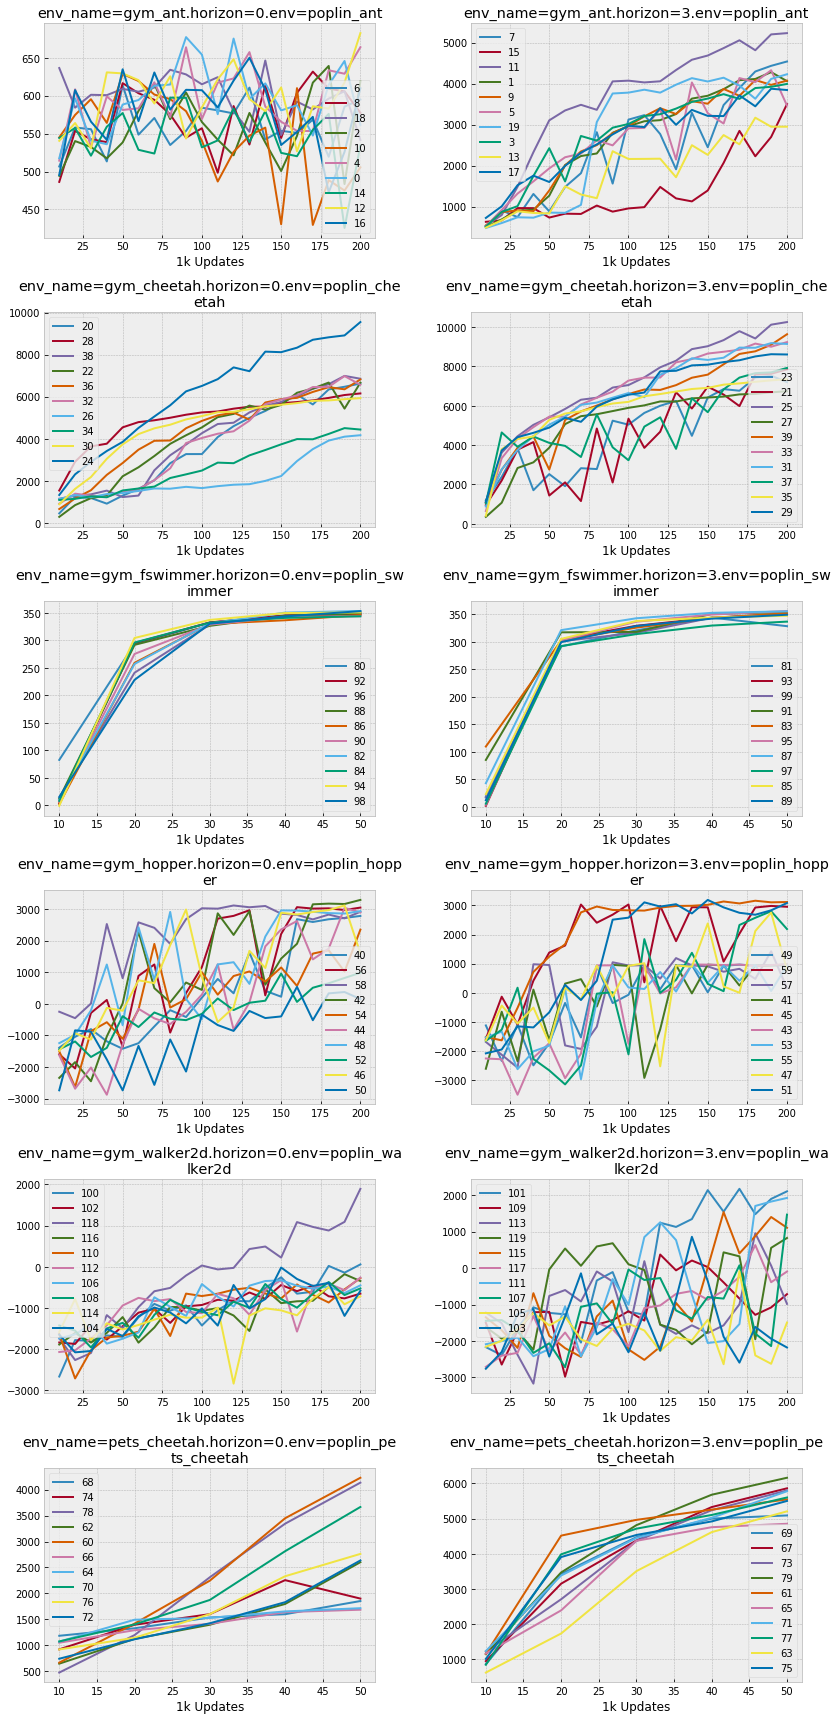

In [6]:
d = '../exp/2020.05.18/1501_sac_mve_poplin_10/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

=== gym_ant
H=0 | 584.89 $\pm$ 129.64 | 200
H=3 | 3977.68 $\pm$ 984.19 | 200
=== gym_hopper
H=0 | 2241.77 $\pm$ 1071.03 | 200
H=3 | 1869.73 $\pm$ 1072.48 | 200
=== gym_fswimmer
H=0 | 344.32 $\pm$ 3.79 | 200
H=3 | 344.31 $\pm$ 6.17 | 200
=== gym_cheetah
H=0 | 6211.28 $\pm$ 1464.77 | 200
H=3 | 8211.56 $\pm$ 1125.93 | 200
=== gym_walker2d
H=0 | -469.51 $\pm$ 806.12 | 200
H=3 | -242.61 $\pm$ 1672.62 | 200
=== pets_cheetah
H=0 | 2260.58 $\pm$ 688.20 | 200
H=3 | 5086.40 $\pm$ 295.14 | 200
['gym_ant' 'gym_hopper' 'gym_fswimmer' 'gym_cheetah' 'gym_walker2d'
 'pets_cheetah']
SAC-MVE ($H=0$) & 584.89 $\pm$ 129.64 & 2241.77 $\pm$ 1071.03 & 344.32 $\pm$ 3.79 & 6211.28 $\pm$ 1464.77 & -469.51 $\pm$ 806.12 & 2260.58 $\pm$ 688.20 \\
SAC-MVE ($H=3$) & 3977.68 $\pm$ 984.19 & 1869.73 $\pm$ 1072.48 & 344.31 $\pm$ 6.17 & 8211.56 $\pm$ 1125.93 & -242.61 $\pm$ 1672.62 & 5086.40 $\pm$ 295.14 \\


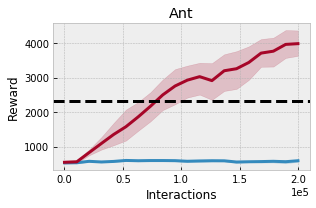

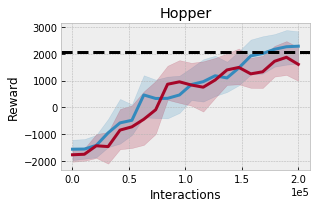

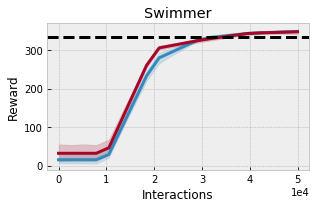

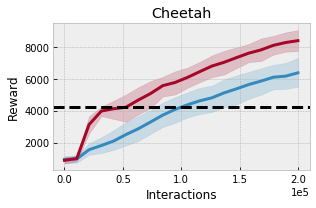

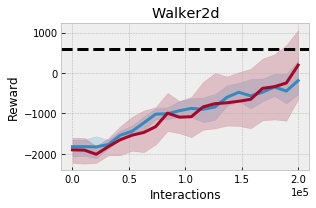

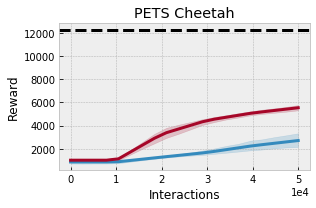

In [18]:
env_raws = ['gym_ant', 'gym_hopper', 'gym_fswimmer', 'gym_cheetah', 'gym_walker2d', 'pets_cheetah']
env_pretties = ['Ant', 'Hopper', 'Swimmer', 'Cheetah', 'Walker2d', 'PETS Cheetah']
poplin_lims = [2330, 2055, 334, 4235, 597, 12227.9]

table_data = []
for env, env_pretty, poplin_lim in zip(env_raws, env_pretties, poplin_lims):
    groups = []
    print(f'=== {env}')
    for H in [0,3]:
        I = (all_summary['env_name'] == env) & (all_summary['agent.params.horizon'] == str(H))
        t = all_summary[I]
        groups.append({
            'roots': t.d.values,
            'tag': str(H),
        })
        
        all_rews = []
        for d in t.d.values:
            fname = f'{d}/eval.latest.mean.full/rews.csv'
            if os.path.exists(fname):
                rews = np.loadtxt(fname, delimiter=',')
                all_rews.append(rews)
        if len(all_rews) > 0:
            all_rews = np.concatenate(all_rews)
            mu = np.mean(all_rews)
            sigma = np.std(all_rews)
            s = f'{mu:.2f} $\\pm$ {sigma:.2f}'
            table_data.append({'env': env, 'H': str(H), 's': s})
            print(f"H={H} | {s} | {len(all_rews)}")

    plot_ablation(
        groups = groups,
        save=f'../data/fig/poplin_{env}.pdf',
        title=env_pretty,
#         xmax=5e5,
        legend=False,
        axhline=poplin_lim,
    )
    
df = pd.DataFrame(table_data)
for H, dfH in df.groupby('H'):
    if H == '0':
        print(dfH.env.values)
    s = f'SAC-MVE ($H={H}$) & '
    s += ' & '.join(dfH.s.values)
    s += r' \\'
    print(s)